### **Notebook to make predictions with reprocessed Yoneda data and EFLUX2** 

##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [2]:
# Study to Download
study_slug = 'biodesign_yoneda_set3_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [3]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [4]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14400,Biodesign_Yoneda_set3_reprocessed,15006,EVOL33-LN-G-R1,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15030,EVOL33-LN-G-R1,NaN,WP_000104864_1,0,FPKM,0.0,14.0
1,14400,Biodesign_Yoneda_set3_reprocessed,15007,EVOL33-LN-G-R2,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15031,EVOL33-LN-G-R2,NaN,WP_000104864_1,0,FPKM,0.0,14.0
2,14400,Biodesign_Yoneda_set3_reprocessed,15008,EVOL33-LN-G-R3,R. Opacus adaptively evolved strain1 with 1.0 ...,Transcriptomics,15032,EVOL33-LN-G-R3,NaN,WP_000104864_1,0,FPKM,0.0,14.0
3,14400,Biodesign_Yoneda_set3_reprocessed,14991,EVOL33-LN-LP-R1,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15015,EVOL33-LN-LP-R1,NaN,WP_000104864_1,0,FPKM,0.0,24.0
4,14400,Biodesign_Yoneda_set3_reprocessed,14992,EVOL33-LN-LP-R2,R. Opacus adaptively evolved strain1 with 0.75...,Transcriptomics,15016,EVOL33-LN-LP-R2,NaN,WP_000104864_1,0,FPKM,0.0,24.0


##### **Load Genome Scale Model**

In [5]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 Code**

In [6]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [7]:
#Function to construct df from EFLUX2 functions: Needs to be modified for multiple time points!!!!!
def construct_trans_df(transdata, linename):
    transdataWTPR1 = transdata[transdata['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [8]:
#Function for EFLUX2 Predictions, calls Eflux2:
def eflux2_pred(model, transcriptdf, linename, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
    return eflux2sol

In [9]:
#Function for predictions for three replicates, averaging the solutions and calculating the standard deviation:
def eflux2_pred_for_three_reps(model, transcriptdf, linename1, linename2, linename3, substrate):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = construct_trans_df(transcriptdf, linename1)
    transdata_R2 = construct_trans_df(transcriptdf, linename2)
    transdata_R3 = construct_trans_df(transcriptdf, linename3)
 
    eflux2sol_R1 = eflux2_pred(model, transdata_R1, linename1, substrate)
    eflux2sol_R2 = eflux2_pred(model, transdata_R2, linename2, substrate)
    eflux2sol_R3 = eflux2_pred(model, transdata_R3, linename3, substrate)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

##### **Wild Type**

In [10]:
eflux2sol, eflux2sol_std = eflux2_pred_for_three_reps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose')

FBA status optimal
FBA solution 0.6189480042770429


EFlux2 status optimal
EFlux2 solution 6061.032453101393
FBA status optimal
FBA solution 0.2103749195934234


EFlux2 status optimal
EFlux2 solution 501.0415458593998
FBA status optimal
FBA solution 0.5044710616634362


EFlux2 status optimal
EFlux2 solution 4746.058023566714


##### **Save solution to data frame**

In [11]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [12]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [13]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
    return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [14]:
def scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'], dtype=np.float64)
    scalepred_fluxes = pd.DataFrame(index=predictions.index, columns= ['fluxes'], dtype=np.float64)
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scale_factor = (sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scale_factor = (sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:   
        print('Unknown Substrate')
    scalepred_fluxes = predictions*scale_factor.values
    scalepred_stds = stdpredictions*scale_factor.values
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [15]:
def add_pred_fluxes_to_13c_df(observed_fluxes, predictions, stdpredictions, substrate, method, strain):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' ' + str(strain) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' ' + str(strain) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [16]:
obspred_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, eflux2soldf, eflux2solstddf, 'glucose', 'EFLUX2', 'WT')

In [17]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000


### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [18]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' + str(strain) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

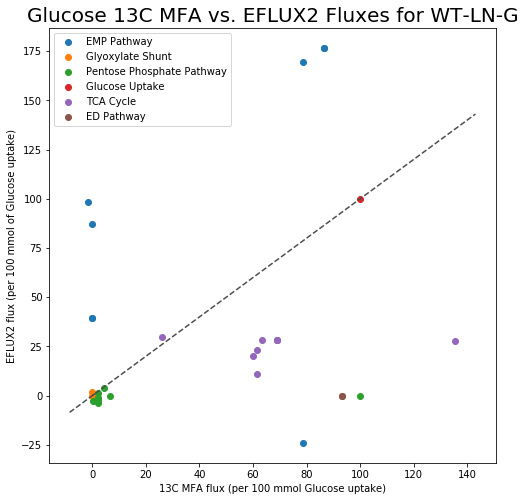

In [19]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G', strain='WT')

##### **Plot observations vs. predictions with confidence intervals**

In [20]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, linename, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename, fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

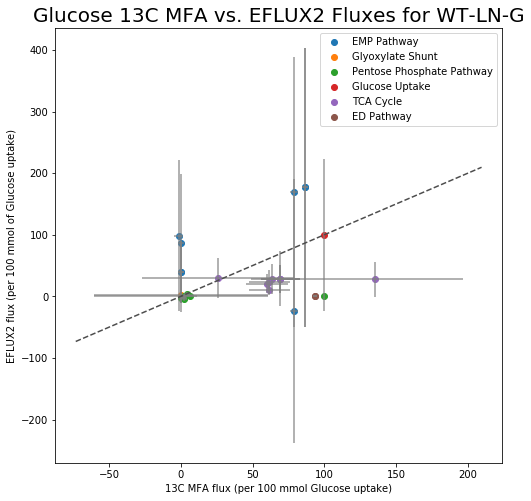

In [21]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='WT-LN-G', strain='WT')

##### **EVOL33-LN-G**

In [22]:
eflux2sol_evol33, eflux2sol_std_evol33 = eflux2_pred_for_three_reps(model, df_Trans, 'EVOL33-LN-G-R1', 'EVOL33-LN-G-R2','EVOL33-LN-G-R3', 'glucose')

FBA status optimal
FBA solution 0.513461195241949


EFlux2 status optimal
EFlux2 solution 4529.046784026705
FBA status optimal
FBA solution 1.0640706653244332


EFlux2 status optimal
EFlux2 solution 35378.080502335724
FBA status optimal
FBA solution 0.6680123100906015


EFlux2 status optimal
EFlux2 solution 10008.896471093181


##### **Save solution to data frame**

In [23]:
eflux2soldf_evol33 = pd.DataFrame(eflux2sol_evol33, columns=['fluxes'])
eflux2solstddf_evol33 = pd.DataFrame(eflux2sol_std_evol33, columns=['stds'])

##### **Check External Metabolites solution**

In [24]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [25]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if eflux2soldf.loc[i,:].values>=0.0001:
        display(eflux2soldf.loc[i,:])

fluxes    25.397693
Name: EX_h2o_e, dtype: float64

fluxes    7.151126
Name: EX_h_e, dtype: float64

fluxes    1.080847
Name: EX_ala__L_e, dtype: float64

fluxes    2.294863
Name: EX_acald_e, dtype: float64

fluxes    0.945514
Name: EX_ala__D_e, dtype: float64

fluxes    0.040514
Name: EX_succ_e, dtype: float64

fluxes    10.404635
Name: EX_co2_e, dtype: float64

fluxes    1.822086
Name: EX_val__L_e, dtype: float64

##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [26]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, eflux2soldf_evol33, eflux2solstddf_evol33, 'glucose', 'EFLUX2', 'EVOL33')

In [27]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000


#### Plot EFLUX2 vs 13C MFA

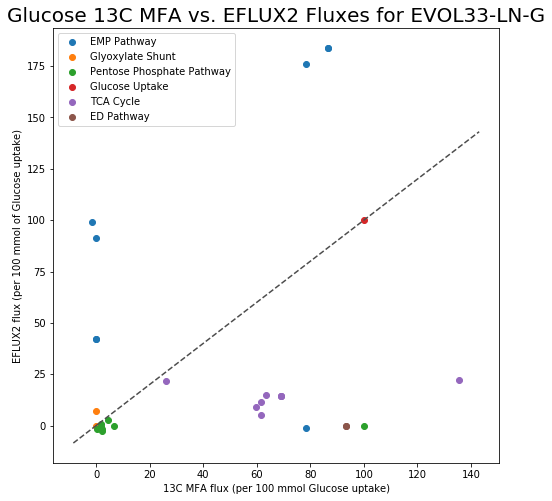

In [28]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='EVOL33-LN-G', strain='EVOL33')

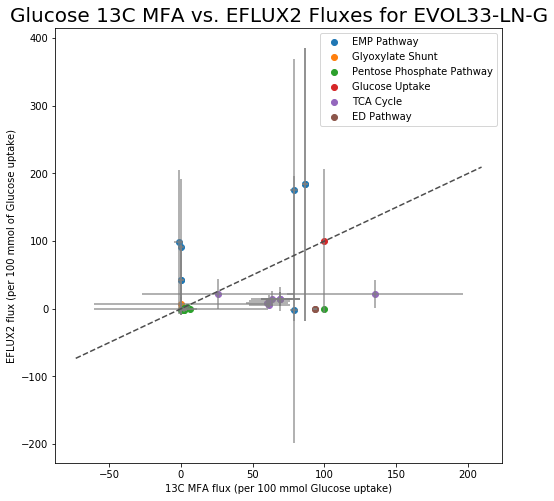

In [29]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2',linename='EVOL33-LN-G', strain='EVOL33')

##### **EVOL40-LN-G**

In [30]:
eflux2sol_evol40, eflux2sol_std_evol40 = eflux2_pred_for_three_reps(model, df_Trans, 'EVOL40-LN-G-R1', 'EVOL40-LN-G-R2','EVOL40-LN-G-R3', 'glucose')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.7564651818190398


EFlux2 status optimal
EFlux2 solution 15441.907296206984
FBA status optimal
FBA solution 0.2679175683521312


EFlux2 status optimal
EFlux2 solution 812.6212938087916
FBA status optimal
FBA solution 0.39491889684257026


EFlux2 status optimal
EFlux2 solution 2094.5328792689043


##### **Save solution to data frame**

In [31]:
eflux2soldf_evol40 = pd.DataFrame(eflux2sol_evol40, columns=['fluxes'])
eflux2solstddf_evol40 = pd.DataFrame(eflux2sol_std_evol40, columns=['stds'])

##### **Add  Glucose EVOL33 EFLUX2 and SPOT flux values to glucosel fluxes dataframe**

In [32]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, eflux2soldf_evol40, eflux2solstddf_evol40, 'glucose', 'EFLUX2', strain='EVOL40')

In [33]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Plot EFLUX2 vs 13C MFA

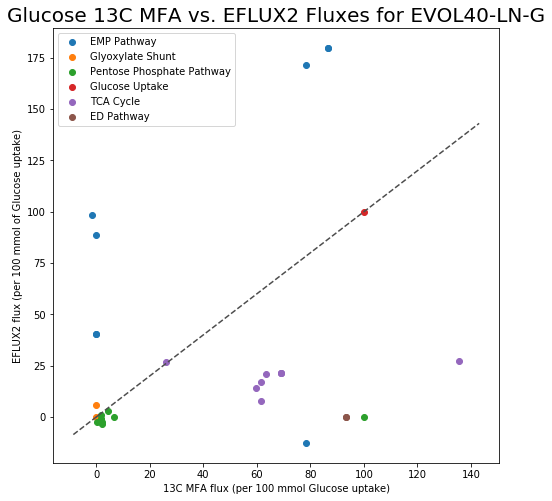

In [34]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='EFLUX2',linename='EVOL40-LN-G', strain='EVOL40')

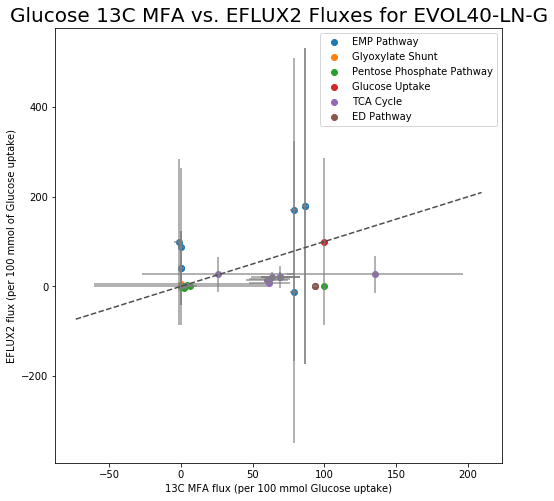

In [35]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='EFLUX2', linename='EVOL40-LN-G', strain='EVOL40')

#### Glucose EFlux Flux Map

Define a function to convert a predicted flux data frame column to a flux map

In [36]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if pd.isnull(row['Location on map'])!=True:
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)
    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

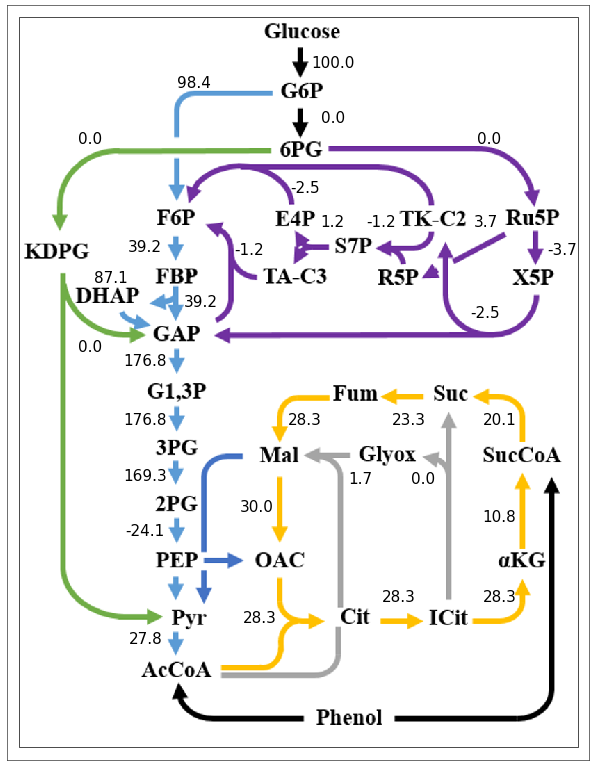

In [37]:
map_flux_results(obspred_fluxes, 'EFLUX2 WT Value')

### Run glucose flux FBA

In [38]:
#Function for EFLUX2 and SPOT Predictions:
def FBA_pred(model, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            medium["EX_phenol_e"] = 100#sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 100#sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        fbasol = model.optimize()
    return fbasol

In [39]:
fbasol =  FBA_pred(model, 'glucose') 

In [40]:
#Function for EFLUX2 and SPOT Predictions:
def pFBA_pred(model, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            medium["EX_phenol_e"] = 100#sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 100#sub_uptake_rate
            medium["EX_phenol_e"] = 0
            #model.reactions.get_by_id('EX_glc__D_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        pfbasol = cobra.flux_analysis.pfba(model)
    return pfbasol

In [41]:
pfbasol =  FBA_pred(model, 'glucose') 

### Add Glucose FBA flux values to test_df 

In [42]:
# fbasoldf = pd.DataFrame(solutionphe, columns=['fluxes'])

In [43]:
# obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, solutionphe, None, 'phenol', 'FBA')

In [44]:
FBA_fluxes_glu = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_glu = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_glu += min([get_flux_value(v, fbasol) for v in and_split])
    FBA_fluxes_glu.append(flux_value_glu)
    
glucose_fluxes['FBA Value'] = FBA_fluxes_glu
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value,FBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814,138.989792
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806,-131.866120
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
pFBA_fluxes_glu = []
for _, row in glucose_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_glu = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_glu += min([get_flux_value(v, pfbasol) for v in and_split])
    pFBA_fluxes_glu.append(flux_value_glu)
    
glucose_fluxes['pFBA Value'] = pFBA_fluxes_glu
glucose_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value,FBA Value,pFBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620,96.747763,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000,0.000000
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000,0.000000
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104,73.558865,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814,138.989792,138.989792
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806,-131.866120,-131.866120
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Get r<sup>2</sup>  values 

In [62]:
# remove Energy molecule reactions as they are outliers
r_squared_df = glucose_fluxes#[~glucose_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH'])]


_, _, EFlux_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['EFLUX2 WT Value'])
#_, _, Spot_r, _, _ = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['SPOT WT Value'])
_, _, FBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['FBA Value'])
_, _, pFBA_r,   _, _  = scipy.stats.linregress(r_squared_df['Flux'], r_squared_df['pFBA Value'])

print(f'E-Flux2 vs 13C-MFA r-squared: {EFlux_r**2:.4F}')
#print(f'SPOT vs 13C-MFA r-squared: {Spot_r**2:.4F}')
print(f'FBA vs 13C-MFA r-squared: {FBA_r**2:.4F}')
print(f'pFBA vs 13C-MFA r-squared: {pFBA_r**2:.4F}')

E-Flux2 vs 13C-MFA r-squared: 0.0824
FBA vs 13C-MFA r-squared: 0.1032
pFBA vs 13C-MFA r-squared: 0.1032


In [47]:
r_squared_df

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 WT Value,EFLUX2 WT std Value,EFLUX2 EVOL33 Value,EFLUX2 EVOL33 std Value,EFLUX2 EVOL40 Value,EFLUX2 EVOL40 std Value,FBA Value,pFBA Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,100.000000,65.054687,100.000000,56.201350,100.000000,98.216868,100.000000,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,98.410410,64.320213,98.902692,55.785026,98.624873,97.481620,96.747763,96.747763
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000,0.000000
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,39.233457,26.438825,42.054199,27.374995,40.597578,43.554534,0.000000,0.000000
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,87.076833,59.097432,91.079022,52.816689,88.820387,92.240104,73.558865,73.558865
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356,152.464356
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,176.766511,119.396211,183.961714,106.317699,179.901101,185.688454,152.464356,152.464356
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,169.334371,115.674332,175.889250,101.933569,171.304628,177.708814,138.989792,138.989792
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,-24.085866,112.692807,-1.362192,103.773399,-12.625180,177.447806,-131.866120,-131.866120
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

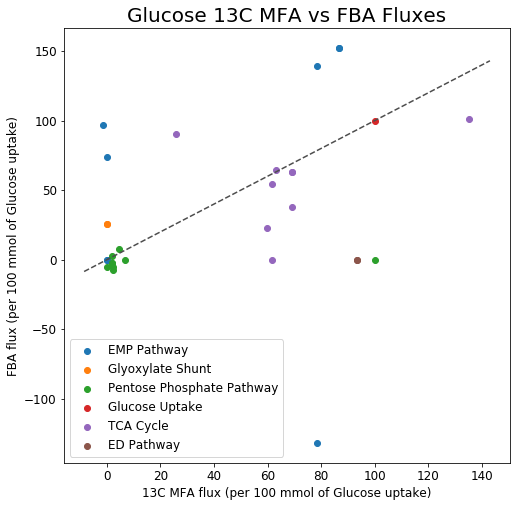

In [48]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")


plt.title(r'Glucose 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Glucose uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of Glucose uptake)')
plt.legend()
plt.show()

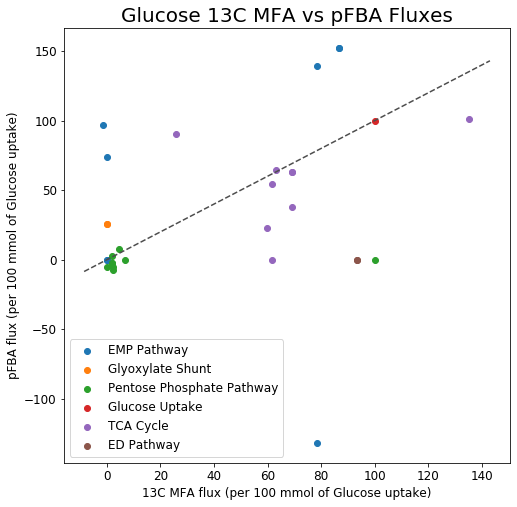

In [49]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(glucose_fluxes['Pathway'])):
    pathway_df = glucose_fluxes[glucose_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['pFBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Glucose 13C MFA vs pFBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of Glucose uptake)')
plt.ylabel(r'pFBA flux (per 100 mmol of Glucose uptake)')
plt.legend()
plt.show()

### Map FBA Fluxes

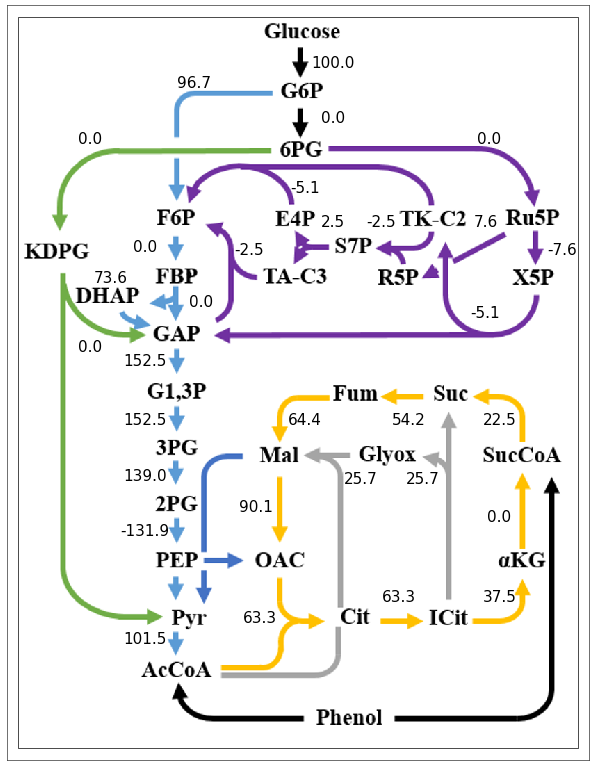

In [50]:
map_flux_results(obspred_fluxes, 'FBA Value')

### Map pFBA Fluxes

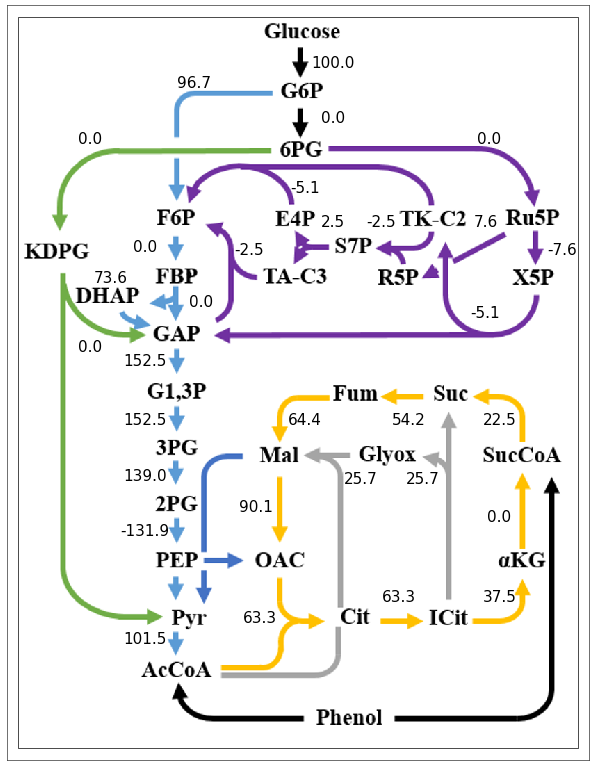

In [51]:
map_flux_results(obspred_fluxes, 'pFBA Value')

### Map 13C MFA Fluxes

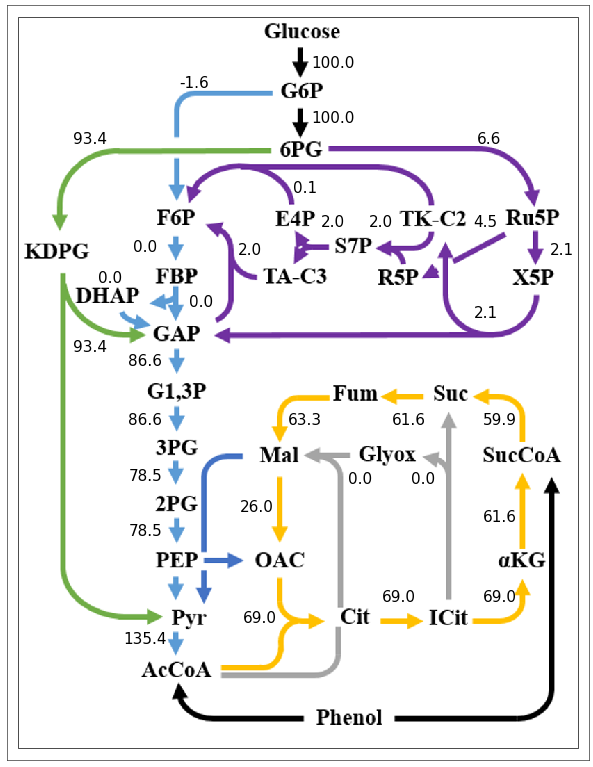

In [52]:
map_flux_results(obspred_fluxes, 'Flux')

#### Load observed growth rates and plot glucose growth rates

In [53]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data.csv', index_col=0)
consumption_and_growth_data

,substrate consumption rate,substrate consumption rate std dev,growth rate,growth rate std dev,yield coefficient,yield coefficient std dev
Yoneda WT 1.5 g/L Phenol,0.703,0.033,0.019,0.001,0.027,0.003
Yoneda Evol33 1.5 g/L Phenol,1.014,0.021,0.034,0.002,0.033,0.002
Yoneda Evol40 1.5 g/L Phenol,0.943,0.030,0.034,0.001,0.036,0.002
"Yoneda WT 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.027,0.000,0.032,0.000,1.150,0.000
"Yoneda Evol33 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",0.043,0.000,0.031,0.000,0.726,0.000
"Yoneda Evol40 1.0 g/L Glucose, 1.0 g/l ammonium sulfate",-0.063,0.000,0.031,0.000,-0.500,0.000
"Yoneda WT 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.021,0.000,0.039,0.000,1.834,0.000
"Yoneda Evol33 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.033,0.000,0.033,0.000,1.006,0.000
"Yoneda Evol40 1.0 g/L Glucose, 0.05 g/l ammonium sulfate",0.017,0.000,0.034,0.000,2.029,0.000
Henson WT 0.5 g/L Phenol,1.422,0.129,0.065,0.001,0.046,0.005


##### **Change index names in order to have same labels as before for plotting purposes**

Yoneda:

    WT 1.5g/L Phenol, 1.0g/L ammonium sulfate (WT-R) ->WT-HN-HP
    Evol33 1.5g/L Phenol, 1.0g/L ammonium sulfate (EVOL33-R) ->EVOL33-HN-HP
    Evol40 1.5g/L Phenol, 1.0g/L ammonium sulfate (EVOL40-R) -> EVOL40-HN-HP
    WT 1.0g/L Glucose, 1.0g/L ammonium sulfate (WT-G) -> WT-HN-G
    Evol33 1.0g/L Glucose, 1.0g/L ammonium sulfate (EVOL33-G) -> EVOL33-HN-G
    Evol40 1.0g/L Glucose, 1.0g/L ammonium sulfate (EVOL40-G) -> EVOL40-HN-G
    WT 1.0g/L Glucose, 0.05g/L ammonium sulfate (WT-G-N) ->WT-LN-G
    Evol33 1.0g/L Glucose, 0.05g/L ammonium sulfate (EVOL33-G-N) ->EVOL33-LN-G
    Evol40 1.0g/L Glucose, 0.05g/L ammonium sulfate (EVOL40-G-N) ->EVOL40-LN-G

Henson:

    WT 0.5g/L Phenol (WT-P-R) ->WT-P
    PVHG6 0.5g/L Phenol (PVHG6-P-R) ->PVHG-P


In [54]:
new_index = pd.Series(['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P'])
consumption_and_growth_data = consumption_and_growth_data.set_index([new_index])

##### **For comparison of predicted and observed growth rates: scale predicted growth rate by multiplying with (observed substrate uptake / predicted substrate uptake)**

In [55]:
def scale_growth_to_sub(solgrowth, soluptake, sub_uptake_2comp):
    factor = abs(sub_uptake_2comp/(-soluptake))
    solgrowthnew = solgrowth*factor
    return solgrowthnew

In [56]:
scaledgrowthrate_wtlng = scale_growth_to_sub(eflux2soldf.loc['Growth_Glucose',:].values[0], eflux2soldf.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['WT-LN-G', 'substrate consumption rate'])
scaledgrowthrate_evol33lng = scale_growth_to_sub(eflux2soldf_evol33.loc['Growth_Glucose',:].values[0], eflux2soldf_evol33.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL33-LN-G',  'substrate consumption rate'])
scaledgrowthrate_evol40lng = scale_growth_to_sub(eflux2soldf_evol40.loc['Growth_Glucose',:].values[0], eflux2soldf_evol40.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['EVOL40-LN-G',  'substrate consumption rate'])

##### **Add scaled values to new dataframe**

In [57]:
allgrowthrates=pd.DataFrame(index=['WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G'], columns=['Growth_Glucose_EFLUX2'], dtype=float)
allgrowthrates.at['WT-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_wtlng#eflux2soldf.loc['Growth_Glucose',:].values[0]#/366.324066
allgrowthrates.at['EVOL33-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_evol33lng#eflux2soldf_evol33.loc['Growth_Glucose',:].values[0]
allgrowthrates.at['EVOL40-LN-G','Growth_Glucose_EFLUX2'] = scaledgrowthrate_evol40lng#eflux2soldf_evol40.loc['Growth_Glucose',:].values[0]
allgrowthrates

,Growth_Glucose_EFLUX2
WT-LN-G,0.001214
EVOL33-LN-G,0.001317
EVOL40-LN-G,0.000850


In [58]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]))
        
    #calculate statistical quantities:
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    
    #r2_1 = round(1 - rss / tss,2) #other way to calculate rsquared
    _, _, growth_r, _, _ = scipy.stats.linregress(observed, predicted)

    #r2 = round(r2_score(observed, predicted),2) #other way to calculate rsquared
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    mae_score = round(maefunc(observed, predicted),2)
    
    plt.xlabel(r'Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'Predicted growth rates [$mmol/gDW/hr$]')
    plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={growth_r**2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [59]:
new_index = pd.Series(['WT-HN-HP','EVOL33-HN-HP', 'EVOL40-HN-HP', 'WT-HN-G', 'EVOL33-HN-G', 'EVOL40-HN-G', 'WT-LN-G', 'EVOL33-LN-G', 'EVOL40-LN-G', 'WT-P', 'PVHG-P'])
consumption_and_growth_data = consumption_and_growth_data.set_index([new_index])


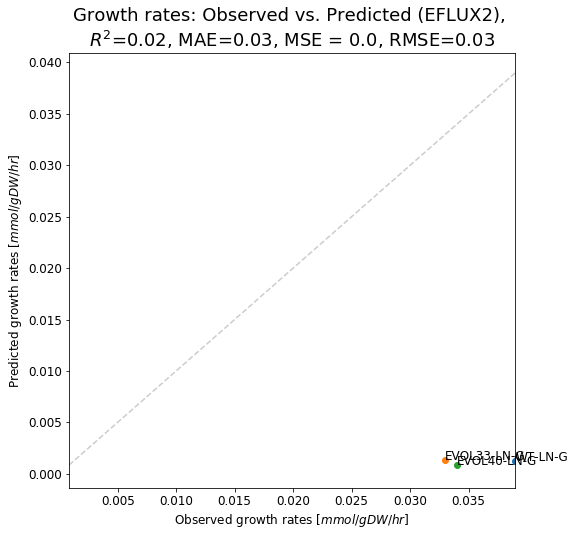

In [60]:
allindices=[str(row) for row in allgrowthrates.index]
scatterplotcompare(consumption_and_growth_data.loc[allindices, 'growth rate'], allgrowthrates.loc[:,'Growth_Glucose_EFLUX2'], allindices, 'EFLUX2')

In [61]:
allgrowthrates.to_csv('allgrowthratesGlucoseEFLUX2.csv', index=True, header= True)